In [196]:
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pickle

# Dataset Preparation

## 1. Fetch Dataset

In [197]:
url = 'moniflora-backup-rtdb.csv'
df = pd.read_csv(url)

## 2. Label Fuzzification & Feature Extraction

In [198]:
def triangular_membership(value, low, mid, high):
    """Triangular membership function"""
    if value < low or value > high:
        return 0
    elif value < mid:
        return (value - low) / (mid - low)
    else:
        return (high - value) / (high - mid)

def determine_label(value):
    temp = value['temperature']
    light = value['light']
    ec = value['conductivity']
    moisture = value['moisture']

    # Define the fuzzy sets
    temp_optimal = triangular_membership(temp, 20, 25, 30)
    light_optimal = triangular_membership(light, 1500, 4500, 7500)
    ec_optimal = triangular_membership(ec, 950, 2000, 3000)
    moisture_optimal = triangular_membership(moisture, 30, 42.5, 55)

    temp_caution = max(triangular_membership(temp, 18, 20, 22), triangular_membership(temp, 28, 30, 32))
    light_caution = max(triangular_membership(light, 1000, 1500, 2000), triangular_membership(light, 7500, 8000, 8500))
    ec_caution = max(triangular_membership(ec, 800, 950, 1100), triangular_membership(ec, 3000, 3200, 3400))
    moisture_caution = max(triangular_membership(moisture, 25, 30, 35), triangular_membership(moisture, 55, 60, 65))

    # Check if the values are within the optimal or caution ranges
    if (temp_optimal > 0 or temp_caution > 0) and (light_optimal > 0 or light_caution > 0) and (ec_optimal > 0 or ec_caution > 0) and (moisture_optimal > 0 or moisture_caution > 0):
        # Check if the values are within the optimal ranges
        if temp_optimal > 0 and light_optimal > 0 and ec_optimal > 0 and moisture_optimal > 0:
            return 0  # Optimal
        else:
            return 1  # Caution
    else:
        return 2  # Extreme

In [199]:
def prepare_data(dataset):
    data = {
        'temperature': [],
        'light': [],
        'conductivity': [],
        'moisture': [],
        'label': []
    }

    for index, value in dataset.iterrows():
        data['temperature'].append(value['temperature'])
        data['light'].append(value['light'])
        data['conductivity'].append(value['conductivity'])
        data['moisture'].append(value['moisture'])
        data['label'].append(determine_label(value))

    return pd.DataFrame(data)

## 3. Dataset Filtration

In [200]:
# Filter the sample to only use latest 2000 data with light intensity more than 600 lux
filtered = df[df['light'] >= 600].tail(2000)
data = prepare_data(filtered)

In [201]:
label_counts = Counter(data['label'])
label_names = {0: 'Optimal', 1: 'Caution', 2: 'Extreme'}

for label, count in label_counts.items():
    print(f'{label_names[label]}: {count} datasets')

Optimal: 235 datasets
Caution: 369 datasets
Extreme: 495 datasets


## 4. Dataset Exploration

In [202]:
data.head()

,temperature,light,conductivity,moisture,label
0,26.1,3821,1872,45,0
1,26.1,4121,1928,38,0
2,28.3,3521,1809,45,0
3,26.0,4221,1892,45,0
4,26.5,4230,1883,48,0


In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   1099 non-null   float64
 1   light         1099 non-null   int64  
 2   conductivity  1099 non-null   int64  
 3   moisture      1099 non-null   int64  
 4   label         1099 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 43.1 KB


In [204]:
data.isnull().sum()

temperature     0
light           0
conductivity    0
moisture        0
label           0
dtype: int64

In [205]:
data.isna().sum()

temperature     0
light           0
conductivity    0
moisture        0
label           0
dtype: int64

## 5. Feature Correlation

In [206]:
def parameter_corr(dataset):
    correlation_matrix = dataset.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

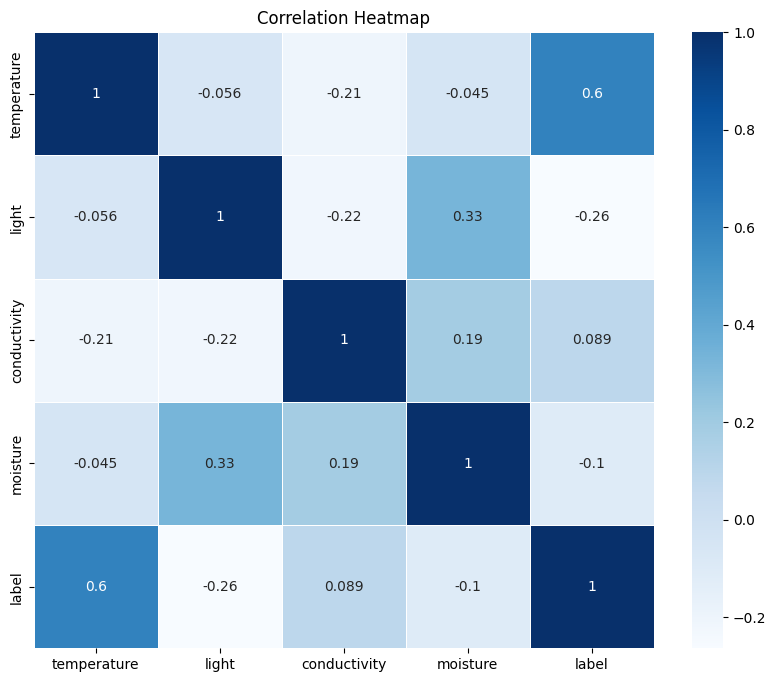

In [207]:
parameter_corr(data)

# Dataset Preprocessing

## 1. Feature selection

In [208]:
X = np.array([data['temperature'], data['light'], data['conductivity'], data['moisture']]).T
y = np.array(data['label'])

# Print y to ensure labels are correctly assigned
print(f'Labels: {y}')
print(f'Feature: {X}')

Labels: [0 0 0 ... 0 0 0]
Feature: [[  26.1 3821.  1872.    45. ]
 [  26.1 4121.  1928.    38. ]
 [  28.3 3521.  1809.    45. ]
 ...
 [  23.8 3857.  1750.    37. ]
 [  24.4 5231.  2412.    36. ]
 [  26.9 4761.  2247.    37. ]]


## 2. Dataset Splitting

In [209]:
# 35% Test, 65% Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=13, stratify=y)

## 3. Imbalanced Handling

In [210]:
### ========== BEFORE SMOTE CHART ==========
counter_before = Counter(y_train)
classes = list(counter_before.keys())
counts_before = list(counter_before.values())
### ========== BEFORE SMOTE CHART ==========

In [211]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [212]:
### ========== AFTER SMOTE CHART ==========
counter_after = Counter(y_train_balanced)
counts_after = list(counter_after.values())
### ========== AFTER SMOTE CHART ==========

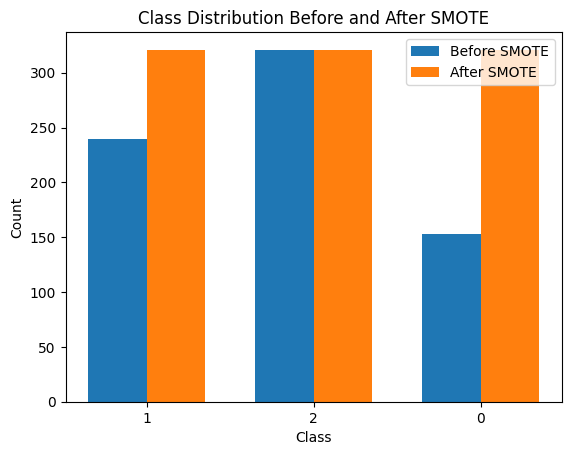

In [213]:
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(classes))

bar1 = ax.bar(index, counts_before, bar_width, label='Before SMOTE')
bar2 = ax.bar(index + bar_width, counts_after, bar_width, label='After SMOTE')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Before and After SMOTE')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes)
ax.legend()

plt.show()

## 4. Scaling (Normalization)

In [214]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Model Engineering

## 1. Model Training

In [215]:
def train_rf(X_train, y_train):
    param_grid = {
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [45, 50, 60] 
    }
        
    grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    forest = RandomForestClassifier(max_depth=5, max_features='log2', **grid_search.best_params_, oob_score=True)
    forest.fit(X_train, y_train)
    print('Best parameters:', best_params)
        
    return forest

In [216]:
model = train_rf(X_train_scaled, y_train_balanced)

Best parameters: {'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 60}


## 2. Hyperparameter Tuning with Stratified K-Fold Cross Validation (SKCV)

In [217]:
stratified_kfold = StratifiedKFold(n_splits=5)
validator = cross_val_score(model, X_test_scaled, y_test, cv=stratified_kfold)
score = model.score(X_test_scaled, y_test)

# Performance Evaluation

## 1. Model & Cross Validation Score

In [218]:
print(f'Random Forest Score: {score}')
print(f'Random Forest Cross Validation Score: {validator}')

Random Forest Score: 0.9766233766233766
Random Forest Cross Validation Score: [0.93506494 0.96103896 0.97402597 0.96103896 0.96103896]


## 2. Performance Metrics

In [219]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        82
           1       0.98      0.95      0.96       129
           2       0.98      0.99      0.99       174

    accuracy                           0.98       385
   macro avg       0.97      0.98      0.97       385
weighted avg       0.98      0.98      0.98       385



## 3. Learning Curve

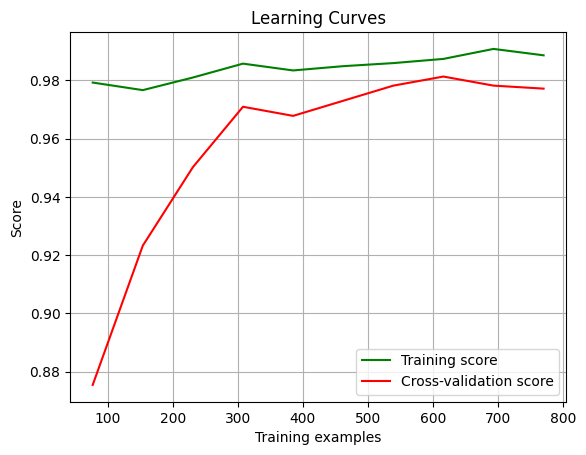

In [220]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train_scaled, y_train_balanced, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training score', color='g')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='r')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Noise Evaluation

In [221]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

## 1. Noise Level Addition

In [222]:
def add_noise(X, noise_level):
    noise = noise_level * np.random.randn(*X.shape)
    return X + noise

In [223]:
noise_level = 0.1 # 10% Noise

X_test_noisy = add_noise(X_test_scaled, noise_level)
y_pred_noisy = model.predict(X_test_noisy)

## 2. Performance Metrics on Noise

In [224]:
accuracy = np.mean(y_pred_noisy == y_test)
precision = precision_score(y_test, y_pred_noisy, average='weighted')
recall = recall_score(y_test, y_pred_noisy, average='weighted')
f1 = f1_score(y_test, y_pred_noisy, average='weighted')

In [225]:
print(classification_report(y_test, y_pred_noisy, digits=2))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        82
           1       0.78      0.82      0.80       129
           2       0.89      0.86      0.88       174

    accuracy                           0.86       385
   macro avg       0.87      0.87      0.87       385
weighted avg       0.86      0.86      0.86       385



## 3. Confusion Matrix on Noise

In [226]:
conf_matrix = confusion_matrix(y_test, y_pred_noisy)

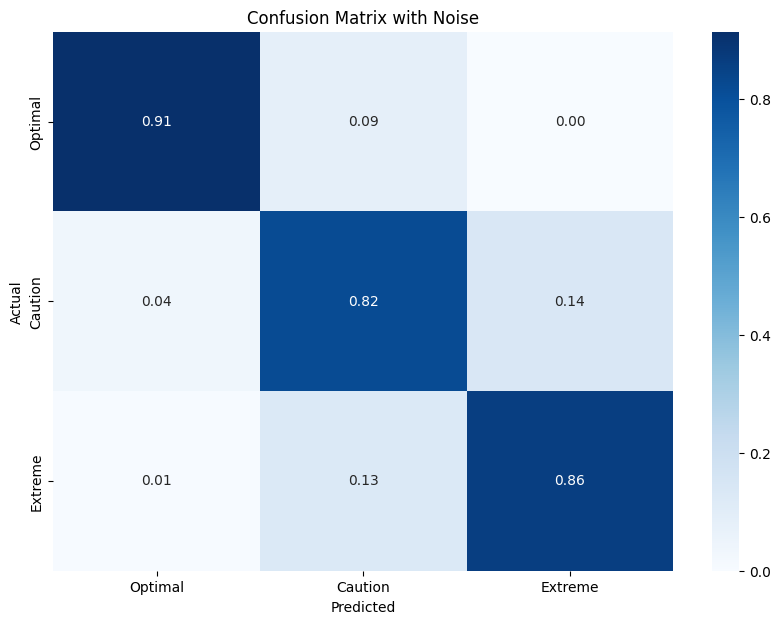

In [227]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Noise')
plt.show()

## 4. Learning Curve (with Noise)

In [228]:
train_sizes, train_scores, test_scores_noisy = learning_curve(
    model, X_train_scaled, y_train_balanced, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

In [229]:
train_scores_mean_noisy = np.mean(train_scores, axis=1)
test_scores_mean_noisy = np.mean(test_scores_noisy, axis=1)

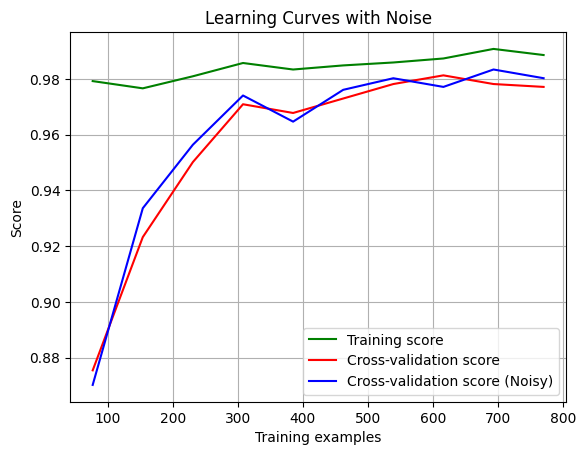

In [230]:
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training score', color='g')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='r')
plt.plot(train_sizes, test_scores_mean_noisy, label='Cross-validation score (Noisy)', color='b')
plt.title('Learning Curves with Noise')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Testing the Model

In [231]:
example_value = { "temperature": 26.9, "light": 4761.0, "conductivity": 2247.0, "moisture": 37.0 }

In [232]:
example_features = np.array([[example_value['temperature'], example_value['light'], example_value['conductivity'], example_value['moisture']]])
example_scaled = scaler.transform(example_features)
example_prediction = model.predict(example_scaled)

In [233]:
model.predict_proba(example_scaled)

array([[0.95387678, 0.03100574, 0.01511748]])

In [234]:
# Save the model and scaler
pickle.dump(model, open('rf_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))